In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [ ]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH 1/30
	 partial train loss (single batch): 0.253703
	 partial train loss (single batch): 0.246091
	 partial train loss (single batch): 0.240565
	 partial train loss (single batch): 0.236035
	 partial train loss (single batch): 0.232056
	 partial train loss (single batch): 0.227894
	 partial train loss (single batch): 0.225192
	 partial train loss (single batch): 0.222588
	 partial train loss (single batch): 0.220434
	 partial train loss (single batch): 0.217674
	 partial train loss (single batch): 0.215859
	 partial train loss (single batch): 0.213537
	 partial train loss (single batch): 0.211849
	 partial train loss (single batch): 0.209737
	 partial train loss (single batch): 0.207807
	 partial train loss (single batch): 0.205362
	 partial train loss (single batch): 0.202946
	 partial train loss (single batch): 0.202055
	 partial train loss (single batch): 0.199840
	 partial train loss (single batch): 0.197937
	 partial train loss (single batch): 0.196257
	 partial train loss (s

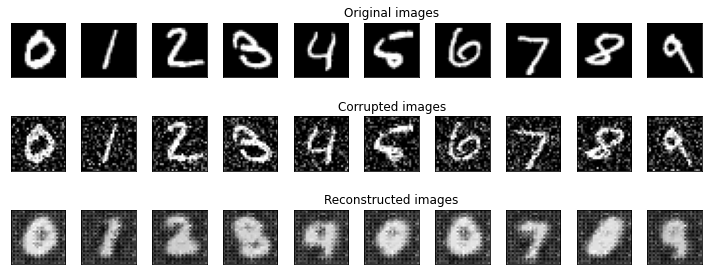

EPOCH 2/30
	 partial train loss (single batch): 0.066586
	 partial train loss (single batch): 0.067033
	 partial train loss (single batch): 0.066129
	 partial train loss (single batch): 0.066240
	 partial train loss (single batch): 0.065807
	 partial train loss (single batch): 0.066082
	 partial train loss (single batch): 0.065684
	 partial train loss (single batch): 0.065548
	 partial train loss (single batch): 0.065890
	 partial train loss (single batch): 0.065314
	 partial train loss (single batch): 0.064439
	 partial train loss (single batch): 0.063771
	 partial train loss (single batch): 0.064861
	 partial train loss (single batch): 0.064723
	 partial train loss (single batch): 0.063805
	 partial train loss (single batch): 0.064114
	 partial train loss (single batch): 0.065405
	 partial train loss (single batch): 0.062941
	 partial train loss (single batch): 0.062460
	 partial train loss (single batch): 0.062853
	 partial train loss (single batch): 0.062698
	 partial train loss (s

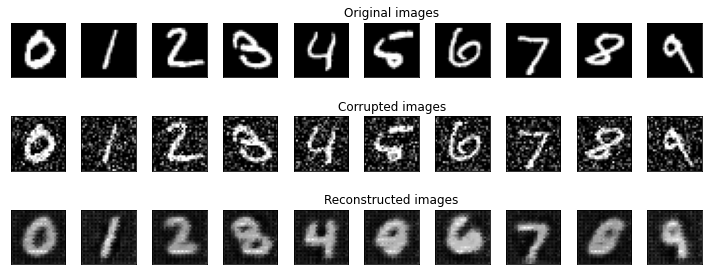

EPOCH 3/30
	 partial train loss (single batch): 0.046217
	 partial train loss (single batch): 0.047071
	 partial train loss (single batch): 0.046470
	 partial train loss (single batch): 0.046675
	 partial train loss (single batch): 0.046425
	 partial train loss (single batch): 0.047111
	 partial train loss (single batch): 0.046793
	 partial train loss (single batch): 0.046517
	 partial train loss (single batch): 0.047438
	 partial train loss (single batch): 0.047345
	 partial train loss (single batch): 0.046179
	 partial train loss (single batch): 0.046028
	 partial train loss (single batch): 0.047074
	 partial train loss (single batch): 0.047145
	 partial train loss (single batch): 0.046428
	 partial train loss (single batch): 0.046633
	 partial train loss (single batch): 0.048260
	 partial train loss (single batch): 0.045695
	 partial train loss (single batch): 0.045445
	 partial train loss (single batch): 0.045800
	 partial train loss (single batch): 0.045939
	 partial train loss (s

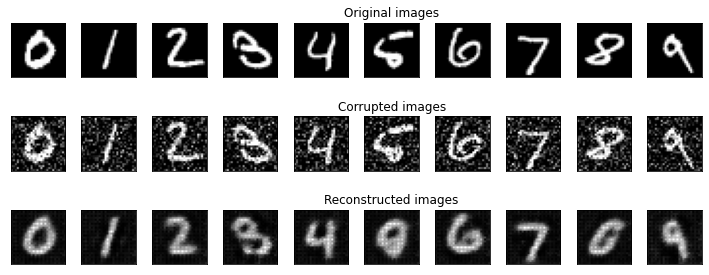

EPOCH 4/30
	 partial train loss (single batch): 0.037460
	 partial train loss (single batch): 0.038293
	 partial train loss (single batch): 0.037505
	 partial train loss (single batch): 0.037626
	 partial train loss (single batch): 0.038022
	 partial train loss (single batch): 0.038816
	 partial train loss (single batch): 0.037906
	 partial train loss (single batch): 0.036837
	 partial train loss (single batch): 0.038836
	 partial train loss (single batch): 0.039076
	 partial train loss (single batch): 0.037858
	 partial train loss (single batch): 0.037824
	 partial train loss (single batch): 0.038207
	 partial train loss (single batch): 0.038242
	 partial train loss (single batch): 0.037404
	 partial train loss (single batch): 0.038154
	 partial train loss (single batch): 0.038980
	 partial train loss (single batch): 0.036625
	 partial train loss (single batch): 0.036361
	 partial train loss (single batch): 0.037269
	 partial train loss (single batch): 0.037151
	 partial train loss (s

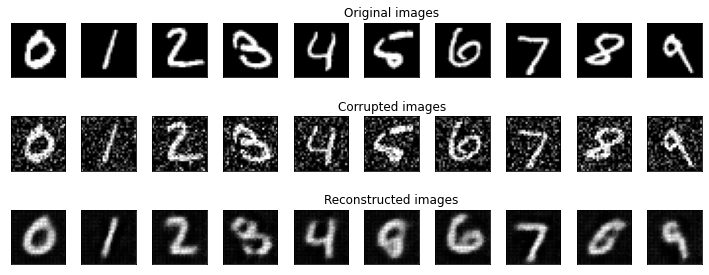

EPOCH 5/30
	 partial train loss (single batch): 0.033142
	 partial train loss (single batch): 0.033658
	 partial train loss (single batch): 0.033124
	 partial train loss (single batch): 0.032889
	 partial train loss (single batch): 0.033948
	 partial train loss (single batch): 0.034402
	 partial train loss (single batch): 0.033447
	 partial train loss (single batch): 0.032086
	 partial train loss (single batch): 0.034470
	 partial train loss (single batch): 0.035157
	 partial train loss (single batch): 0.033980
	 partial train loss (single batch): 0.033740
	 partial train loss (single batch): 0.033716
	 partial train loss (single batch): 0.034077
	 partial train loss (single batch): 0.032952
	 partial train loss (single batch): 0.033829
	 partial train loss (single batch): 0.034781
	 partial train loss (single batch): 0.032602
	 partial train loss (single batch): 0.032133
	 partial train loss (single batch): 0.033248
	 partial train loss (single batch): 0.033057
	 partial train loss (s

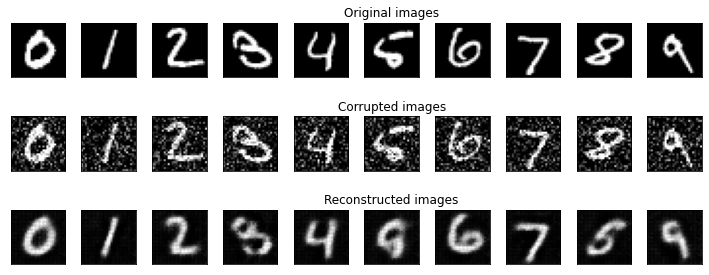

EPOCH 6/30
	 partial train loss (single batch): 0.031419
	 partial train loss (single batch): 0.031835
	 partial train loss (single batch): 0.031324
	 partial train loss (single batch): 0.030906
	 partial train loss (single batch): 0.031878
	 partial train loss (single batch): 0.032487
	 partial train loss (single batch): 0.031690
	 partial train loss (single batch): 0.029850
	 partial train loss (single batch): 0.032800
	 partial train loss (single batch): 0.033342
	 partial train loss (single batch): 0.031980
	 partial train loss (single batch): 0.032084
	 partial train loss (single batch): 0.031743
	 partial train loss (single batch): 0.032333
	 partial train loss (single batch): 0.031161
	 partial train loss (single batch): 0.032298
	 partial train loss (single batch): 0.033145
	 partial train loss (single batch): 0.030863
	 partial train loss (single batch): 0.030449
	 partial train loss (single batch): 0.031506
	 partial train loss (single batch): 0.031488
	 partial train loss (s

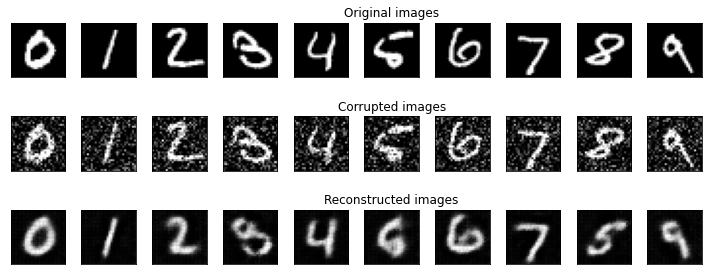

EPOCH 7/30
	 partial train loss (single batch): 0.030247
	 partial train loss (single batch): 0.030774
	 partial train loss (single batch): 0.030387
	 partial train loss (single batch): 0.029908
	 partial train loss (single batch): 0.030835
	 partial train loss (single batch): 0.031202
	 partial train loss (single batch): 0.030493
	 partial train loss (single batch): 0.028711
	 partial train loss (single batch): 0.031740
	 partial train loss (single batch): 0.032426
	 partial train loss (single batch): 0.030780
	 partial train loss (single batch): 0.030970
	 partial train loss (single batch): 0.030783
	 partial train loss (single batch): 0.031325
	 partial train loss (single batch): 0.030025
	 partial train loss (single batch): 0.031326
	 partial train loss (single batch): 0.031878
	 partial train loss (single batch): 0.029450
	 partial train loss (single batch): 0.029341
	 partial train loss (single batch): 0.030400
	 partial train loss (single batch): 0.030378
	 partial train loss (s

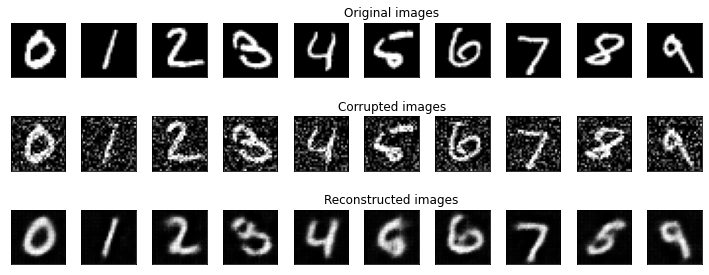

EPOCH 8/30
	 partial train loss (single batch): 0.029363
	 partial train loss (single batch): 0.030245
	 partial train loss (single batch): 0.029526
	 partial train loss (single batch): 0.029113
	 partial train loss (single batch): 0.030222
	 partial train loss (single batch): 0.030524
	 partial train loss (single batch): 0.029943
	 partial train loss (single batch): 0.027899
	 partial train loss (single batch): 0.030961
	 partial train loss (single batch): 0.031791
	 partial train loss (single batch): 0.030044
	 partial train loss (single batch): 0.030357
	 partial train loss (single batch): 0.030076
	 partial train loss (single batch): 0.030651
	 partial train loss (single batch): 0.029473
	 partial train loss (single batch): 0.030685
	 partial train loss (single batch): 0.031435
	 partial train loss (single batch): 0.028846
	 partial train loss (single batch): 0.028679
	 partial train loss (single batch): 0.029500
	 partial train loss (single batch): 0.029730
	 partial train loss (s

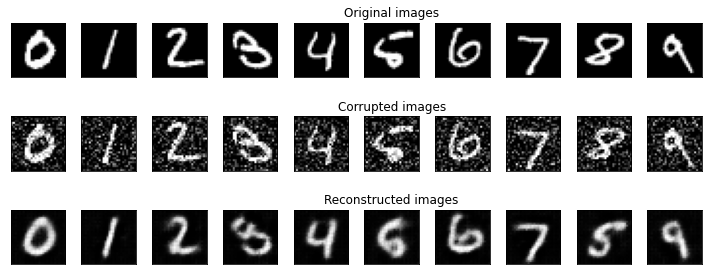

EPOCH 9/30
	 partial train loss (single batch): 0.029063
	 partial train loss (single batch): 0.029497
	 partial train loss (single batch): 0.029029
	 partial train loss (single batch): 0.028627
	 partial train loss (single batch): 0.029535
	 partial train loss (single batch): 0.030017
	 partial train loss (single batch): 0.029495
	 partial train loss (single batch): 0.027406
	 partial train loss (single batch): 0.030517
	 partial train loss (single batch): 0.031282
	 partial train loss (single batch): 0.029554
	 partial train loss (single batch): 0.029981
	 partial train loss (single batch): 0.029719
	 partial train loss (single batch): 0.030166
	 partial train loss (single batch): 0.028880
	 partial train loss (single batch): 0.030202
	 partial train loss (single batch): 0.030960
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.028992
	 partial train loss (single batch): 0.029249
	 partial train loss (s

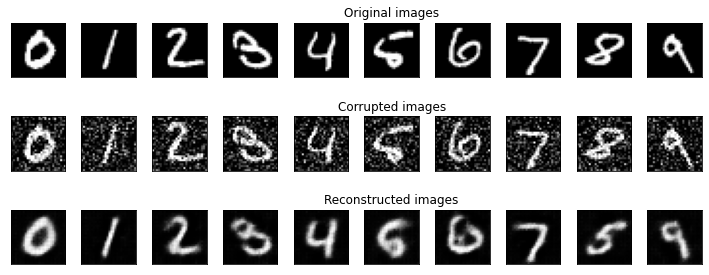

EPOCH 10/30
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.028899
	 partial train loss (single batch): 0.028518
	 partial train loss (single batch): 0.028121
	 partial train loss (single batch): 0.029157
	 partial train loss (single batch): 0.029536
	 partial train loss (single batch): 0.029052
	 partial train loss (single batch): 0.026921
	 partial train loss (single batch): 0.029960
	 partial train loss (single batch): 0.030397
	 partial train loss (single batch): 0.028942
	 partial train loss (single batch): 0.029464
	 partial train loss (single batch): 0.029122
	 partial train loss (single batch): 0.029581
	 partial train loss (single batch): 0.028360
	 partial train loss (single batch): 0.029595
	 partial train loss (single batch): 0.030468
	 partial train loss (single batch): 0.027715
	 partial train loss (single batch): 0.027561
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.028854
	 partial train loss (

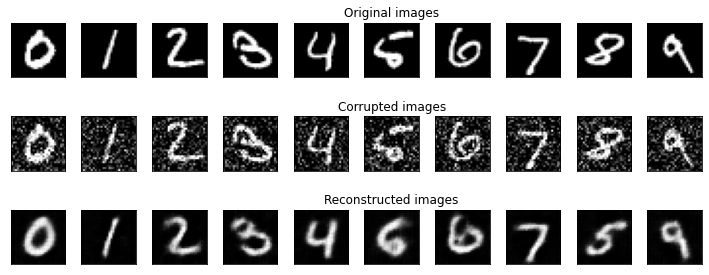

EPOCH 11/30
	 partial train loss (single batch): 0.027893
	 partial train loss (single batch): 0.028744
	 partial train loss (single batch): 0.028230
	 partial train loss (single batch): 0.027867
	 partial train loss (single batch): 0.028792
	 partial train loss (single batch): 0.029145
	 partial train loss (single batch): 0.028625
	 partial train loss (single batch): 0.026381
	 partial train loss (single batch): 0.029466
	 partial train loss (single batch): 0.030104
	 partial train loss (single batch): 0.028404
	 partial train loss (single batch): 0.029016
	 partial train loss (single batch): 0.029171
	 partial train loss (single batch): 0.029048
	 partial train loss (single batch): 0.028005
	 partial train loss (single batch): 0.029349
	 partial train loss (single batch): 0.030209
	 partial train loss (single batch): 0.027335
	 partial train loss (single batch): 0.027419
	 partial train loss (single batch): 0.028509
	 partial train loss (single batch): 0.028344
	 partial train loss (

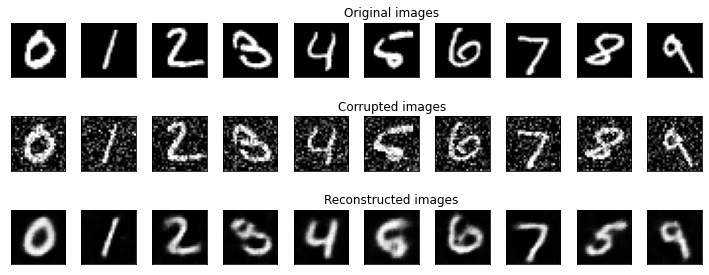

EPOCH 12/30
	 partial train loss (single batch): 0.027520
	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.027808
	 partial train loss (single batch): 0.027455
	 partial train loss (single batch): 0.028305
	 partial train loss (single batch): 0.028817
	 partial train loss (single batch): 0.028091
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.029272
	 partial train loss (single batch): 0.029556
	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.028658
	 partial train loss (single batch): 0.028569
	 partial train loss (single batch): 0.028781
	 partial train loss (single batch): 0.027592
	 partial train loss (single batch): 0.029022
	 partial train loss (single batch): 0.029760
	 partial train loss (single batch): 0.027304
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.027895
	 partial train loss (single batch): 0.028237
	 partial train loss (

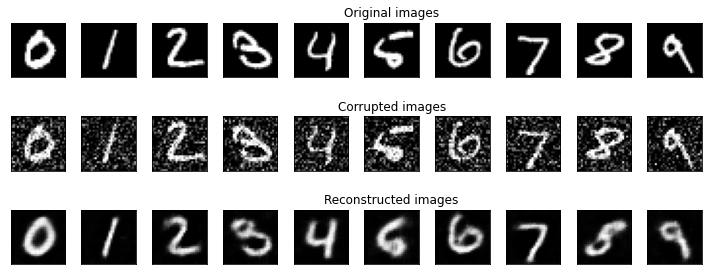

EPOCH 13/30
	 partial train loss (single batch): 0.027148
	 partial train loss (single batch): 0.028035
	 partial train loss (single batch): 0.027779
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.028383
	 partial train loss (single batch): 0.028787
	 partial train loss (single batch): 0.027983
	 partial train loss (single batch): 0.026036
	 partial train loss (single batch): 0.029126
	 partial train loss (single batch): 0.029392
	 partial train loss (single batch): 0.027930
	 partial train loss (single batch): 0.028548
	 partial train loss (single batch): 0.028294
	 partial train loss (single batch): 0.028520
	 partial train loss (single batch): 0.027453
	 partial train loss (single batch): 0.028788
	 partial train loss (single batch): 0.029792
	 partial train loss (single batch): 0.026979
	 partial train loss (single batch): 0.026972
	 partial train loss (single batch): 0.027949
	 partial train loss (single batch): 0.027884
	 partial train loss (

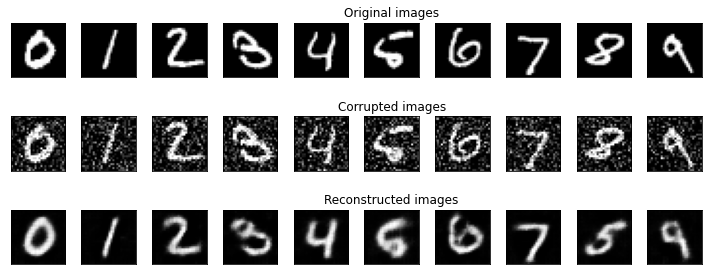

EPOCH 14/30
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.027708
	 partial train loss (single batch): 0.027678
	 partial train loss (single batch): 0.027262
	 partial train loss (single batch): 0.027868
	 partial train loss (single batch): 0.028612
	 partial train loss (single batch): 0.027854
	 partial train loss (single batch): 0.025943
	 partial train loss (single batch): 0.028823
	 partial train loss (single batch): 0.029134
	 partial train loss (single batch): 0.027936
	 partial train loss (single batch): 0.027925
	 partial train loss (single batch): 0.028173
	 partial train loss (single batch): 0.028599
	 partial train loss (single batch): 0.027191
	 partial train loss (single batch): 0.028574
	 partial train loss (single batch): 0.029798
	 partial train loss (single batch): 0.026643
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.027588
	 partial train loss (single batch): 0.027637
	 partial train loss (

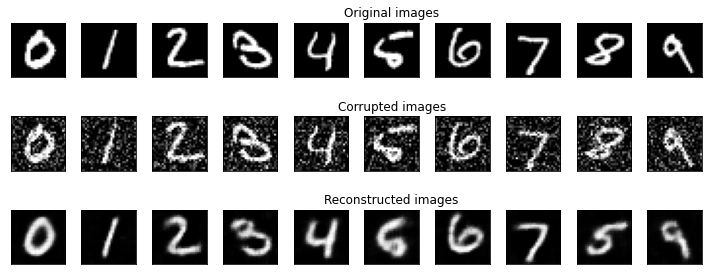

EPOCH 15/30
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.027404
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.027711
	 partial train loss (single batch): 0.028341
	 partial train loss (single batch): 0.027662
	 partial train loss (single batch): 0.025700
	 partial train loss (single batch): 0.028662
	 partial train loss (single batch): 0.029018
	 partial train loss (single batch): 0.027663
	 partial train loss (single batch): 0.027956
	 partial train loss (single batch): 0.028090
	 partial train loss (single batch): 0.027986
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.028531
	 partial train loss (single batch): 0.029212
	 partial train loss (single batch): 0.026485
	 partial train loss (single batch): 0.026376
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch): 0.027584
	 partial train loss (

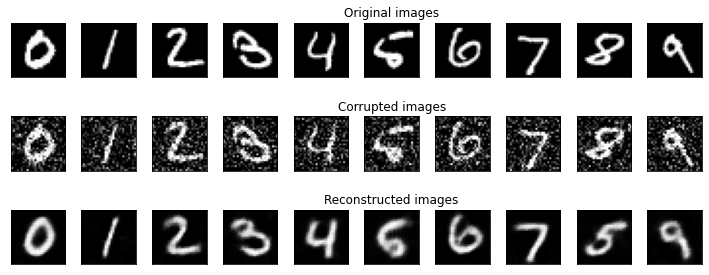

EPOCH 16/30
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.027348
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.026939
	 partial train loss (single batch): 0.027524
	 partial train loss (single batch): 0.028164
	 partial train loss (single batch): 0.027308
	 partial train loss (single batch): 0.025429
	 partial train loss (single batch): 0.028392
	 partial train loss (single batch): 0.028580
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.027785
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.026873
	 partial train loss (single batch): 0.028395
	 partial train loss (single batch): 0.029326
	 partial train loss (single batch): 0.026357
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.027456
	 partial train loss (single batch): 0.027438
	 partial train loss (

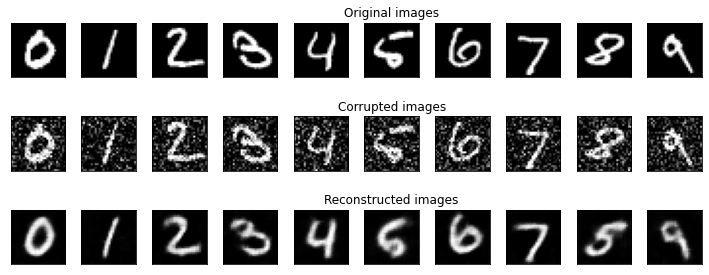

EPOCH 17/30
	 partial train loss (single batch): 0.026664
	 partial train loss (single batch): 0.027093
	 partial train loss (single batch): 0.027123
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.027427
	 partial train loss (single batch): 0.028124
	 partial train loss (single batch): 0.027372
	 partial train loss (single batch): 0.025446
	 partial train loss (single batch): 0.028516
	 partial train loss (single batch): 0.028644
	 partial train loss (single batch): 0.027147
	 partial train loss (single batch): 0.027583
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.028151
	 partial train loss (single batch): 0.029179
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.026154
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch): 0.027183
	 partial train loss (

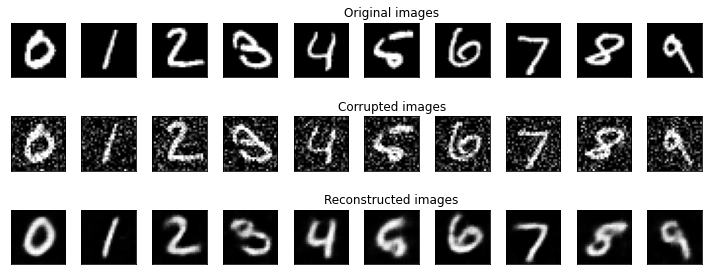

EPOCH 18/30
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.027172
	 partial train loss (single batch): 0.026978
	 partial train loss (single batch): 0.026646
	 partial train loss (single batch): 0.027167
	 partial train loss (single batch): 0.027863
	 partial train loss (single batch): 0.027154
	 partial train loss (single batch): 0.025284
	 partial train loss (single batch): 0.028050
	 partial train loss (single batch): 0.028460
	 partial train loss (single batch): 0.027055
	 partial train loss (single batch): 0.027380
	 partial train loss (single batch): 0.027755
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.026478
	 partial train loss (single batch): 0.027917
	 partial train loss (single batch): 0.028947
	 partial train loss (single batch): 0.025854
	 partial train loss (single batch): 0.025847
	 partial train loss (single batch): 0.027038
	 partial train loss (single batch): 0.027046
	 partial train loss (

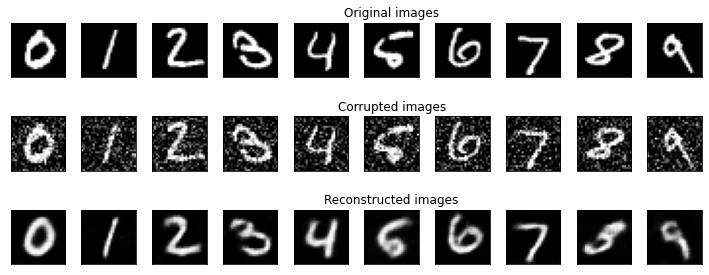

EPOCH 19/30
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.026870
	 partial train loss (single batch): 0.026361
	 partial train loss (single batch): 0.027191
	 partial train loss (single batch): 0.027905
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.025510
	 partial train loss (single batch): 0.028037
	 partial train loss (single batch): 0.028314
	 partial train loss (single batch): 0.027050
	 partial train loss (single batch): 0.027259
	 partial train loss (single batch): 0.027717
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.026444
	 partial train loss (single batch): 0.027785
	 partial train loss (single batch): 0.029112
	 partial train loss (single batch): 0.025921
	 partial train loss (single batch): 0.025807
	 partial train loss (single batch): 0.026939
	 partial train loss (single batch): 0.027034
	 partial train loss (

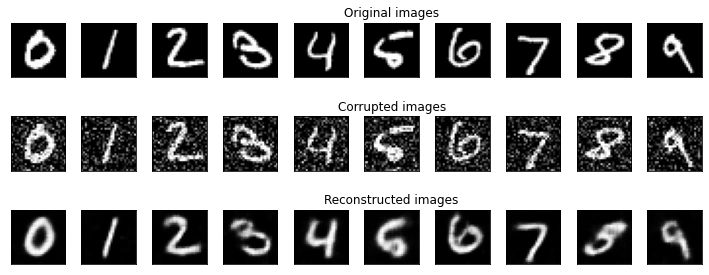

EPOCH 20/30
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.026723
	 partial train loss (single batch): 0.026189
	 partial train loss (single batch): 0.026856
	 partial train loss (single batch): 0.027622
	 partial train loss (single batch): 0.026984
	 partial train loss (single batch): 0.025037
	 partial train loss (single batch): 0.027822
	 partial train loss (single batch): 0.028259
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch): 0.027469
	 partial train loss (single batch): 0.027328
	 partial train loss (single batch): 0.027369
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.027661
	 partial train loss (single batch): 0.028914
	 partial train loss (single batch): 0.025916
	 partial train loss (single batch): 0.025889
	 partial train loss (single batch): 0.026938
	 partial train loss (single batch): 0.027129
	 partial train loss (

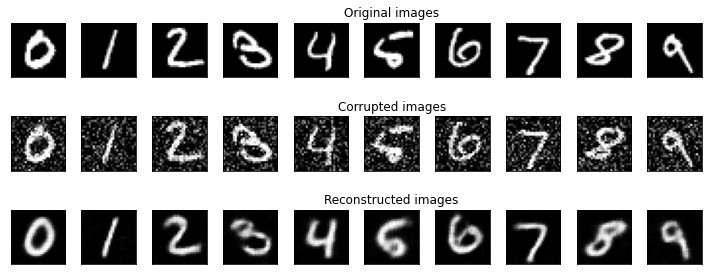

EPOCH 21/30
	 partial train loss (single batch): 0.026048
	 partial train loss (single batch): 0.026751
	 partial train loss (single batch): 0.026745
	 partial train loss (single batch): 0.026277
	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.027594
	 partial train loss (single batch): 0.026776
	 partial train loss (single batch): 0.025147
	 partial train loss (single batch): 0.027609
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.027171
	 partial train loss (single batch): 0.027283
	 partial train loss (single batch): 0.027162
	 partial train loss (single batch): 0.025972
	 partial train loss (single batch): 0.027753
	 partial train loss (single batch): 0.028724
	 partial train loss (single batch): 0.025891
	 partial train loss (single batch): 0.025496
	 partial train loss (single batch): 0.026726
	 partial train loss (single batch): 0.026771
	 partial train loss (

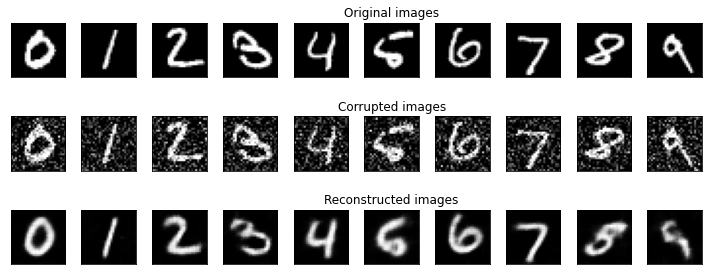

EPOCH 22/30
	 partial train loss (single batch): 0.026078
	 partial train loss (single batch): 0.026657
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026098
	 partial train loss (single batch): 0.026668
	 partial train loss (single batch): 0.027598
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.025061
	 partial train loss (single batch): 0.027752
	 partial train loss (single batch): 0.028090
	 partial train loss (single batch): 0.026841
	 partial train loss (single batch): 0.027033
	 partial train loss (single batch): 0.027227
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.026133
	 partial train loss (single batch): 0.027813
	 partial train loss (single batch): 0.028896
	 partial train loss (single batch): 0.025686
	 partial train loss (single batch): 0.025606
	 partial train loss (single batch): 0.026615
	 partial train loss (single batch): 0.026558
	 partial train loss (

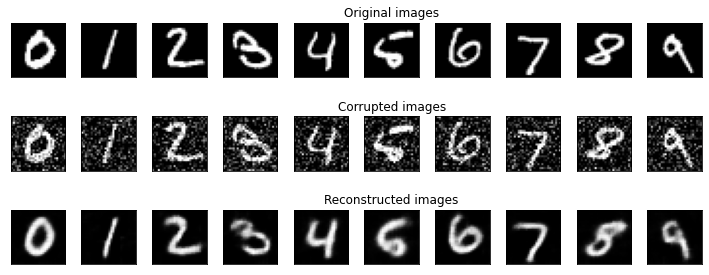

EPOCH 23/30
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.026502
	 partial train loss (single batch): 0.026601
	 partial train loss (single batch): 0.026040
	 partial train loss (single batch): 0.026693
	 partial train loss (single batch): 0.027484
	 partial train loss (single batch): 0.026786
	 partial train loss (single batch): 0.024988
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.027852
	 partial train loss (single batch): 0.026414
	 partial train loss (single batch): 0.026784
	 partial train loss (single batch): 0.027136
	 partial train loss (single batch): 0.027018
	 partial train loss (single batch): 0.025829
	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.028530
	 partial train loss (single batch): 0.025670
	 partial train loss (single batch): 0.025425
	 partial train loss (single batch): 0.026420
	 partial train loss (single batch): 0.026570
	 partial train loss (

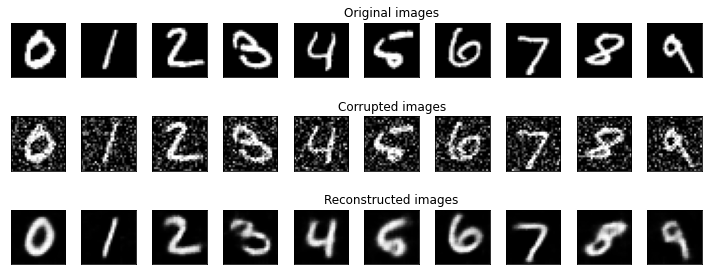

EPOCH 24/30
	 partial train loss (single batch): 0.025851
	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.026457
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.026518
	 partial train loss (single batch): 0.027246
	 partial train loss (single batch): 0.026812
	 partial train loss (single batch): 0.024936
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch): 0.027792
	 partial train loss (single batch): 0.026616
	 partial train loss (single batch): 0.026712
	 partial train loss (single batch): 0.026913
	 partial train loss (single batch): 0.027016
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.027265
	 partial train loss (single batch): 0.028501
	 partial train loss (single batch): 0.025443
	 partial train loss (single batch): 0.025437
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.026505
	 partial train loss (

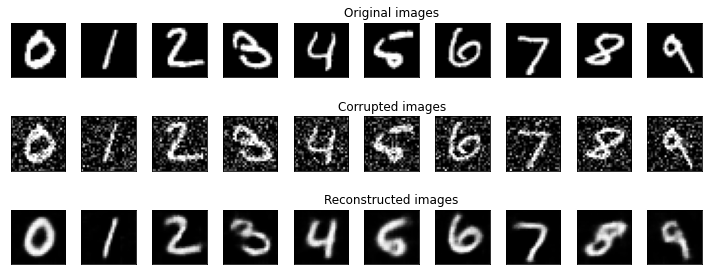

EPOCH 25/30
	 partial train loss (single batch): 0.025641
	 partial train loss (single batch): 0.026366
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch): 0.026050
	 partial train loss (single batch): 0.026540
	 partial train loss (single batch): 0.027078
	 partial train loss (single batch): 0.026487
	 partial train loss (single batch): 0.024812
	 partial train loss (single batch): 0.027692
	 partial train loss (single batch): 0.027715
	 partial train loss (single batch): 0.026414
	 partial train loss (single batch): 0.026523
	 partial train loss (single batch): 0.026960
	 partial train loss (single batch): 0.026833
	 partial train loss (single batch): 0.025882
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.028520
	 partial train loss (single batch): 0.025595
	 partial train loss (single batch): 0.025535
	 partial train loss (single batch): 0.026252
	 partial train loss (single batch): 0.026326
	 partial train loss (

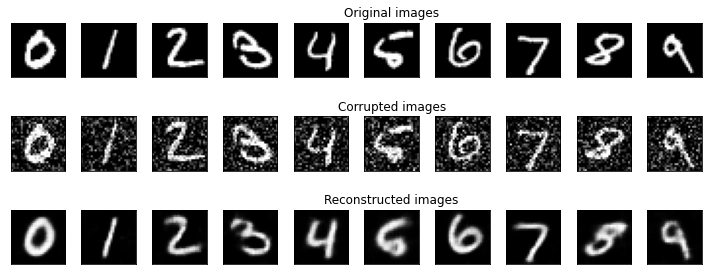

EPOCH 26/30
	 partial train loss (single batch): 0.025853
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.026148
	 partial train loss (single batch): 0.025883
	 partial train loss (single batch): 0.026315
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.026522
	 partial train loss (single batch): 0.024641
	 partial train loss (single batch): 0.027171
	 partial train loss (single batch): 0.027460
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.026660
	 partial train loss (single batch): 0.026813
	 partial train loss (single batch): 0.026666
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.027281
	 partial train loss (single batch): 0.028460
	 partial train loss (single batch): 0.025866
	 partial train loss (single batch): 0.025112
	 partial train loss (single batch): 0.026223
	 partial train loss (single batch): 0.026410
	 partial train loss (

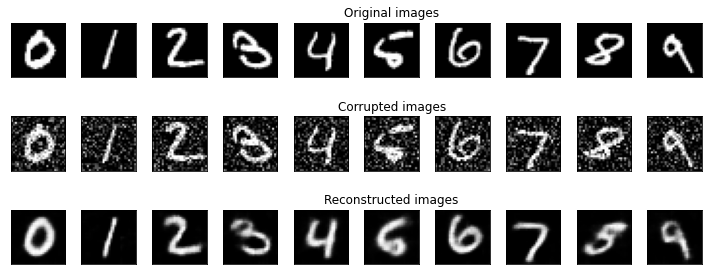

EPOCH 27/30
	 partial train loss (single batch): 0.025497
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch): 0.026432
	 partial train loss (single batch): 0.025733
	 partial train loss (single batch): 0.026509
	 partial train loss (single batch): 0.026837
	 partial train loss (single batch): 0.026230
	 partial train loss (single batch): 0.024695
	 partial train loss (single batch): 0.027409
	 partial train loss (single batch): 0.027604
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.027041
	 partial train loss (single batch): 0.026742
	 partial train loss (single batch): 0.025664
	 partial train loss (single batch): 0.027309
	 partial train loss (single batch): 0.028463
	 partial train loss (single batch): 0.025497
	 partial train loss (single batch): 0.025119
	 partial train loss (single batch): 0.026136
	 partial train loss (single batch): 0.026202
	 partial train loss (

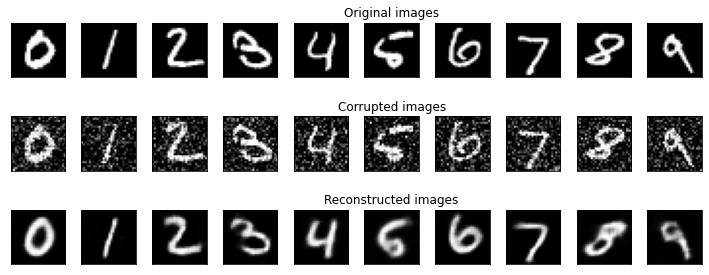

EPOCH 28/30
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch): 0.026068
	 partial train loss (single batch): 0.026372
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.026186
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.026081
	 partial train loss (single batch): 0.024494
	 partial train loss (single batch): 0.027149
	 partial train loss (single batch): 0.027506
	 partial train loss (single batch): 0.025923
	 partial train loss (single batch): 0.026332
	 partial train loss (single batch): 0.026862
	 partial train loss (single batch): 0.026372
	 partial train loss (single batch): 0.025539
	 partial train loss (single batch): 0.027135
	 partial train loss (single batch): 0.028183
	 partial train loss (single batch): 0.025567
	 partial train loss (single batch): 0.025024
	 partial train loss (single batch): 0.025909
	 partial train loss (single batch): 0.026246
	 partial train loss (

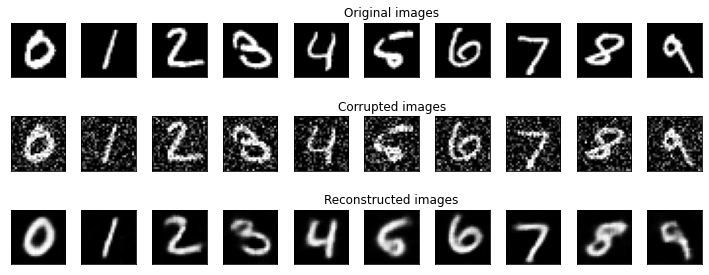

EPOCH 29/30
	 partial train loss (single batch): 0.025553
	 partial train loss (single batch): 0.025992
	 partial train loss (single batch): 0.026136
	 partial train loss (single batch): 0.025701
	 partial train loss (single batch): 0.026409
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.026188
	 partial train loss (single batch): 0.024513
	 partial train loss (single batch): 0.027190
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.025769
	 partial train loss (single batch): 0.026521
	 partial train loss (single batch): 0.026700
	 partial train loss (single batch): 0.026633
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.028257
	 partial train loss (single batch): 0.025413
	 partial train loss (single batch): 0.025244
	 partial train loss (single batch): 0.026029
	 partial train loss (single batch): 0.026051
	 partial train loss (

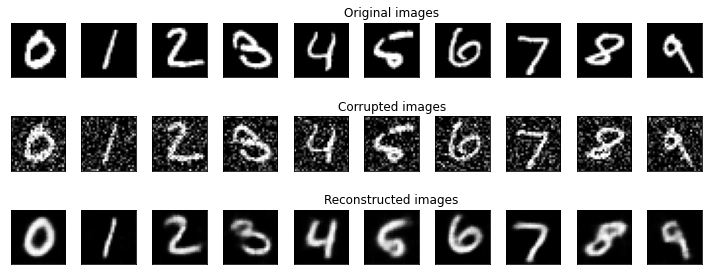

EPOCH 30/30
	 partial train loss (single batch): 0.025514
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.025850
	 partial train loss (single batch): 0.025738
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.026671
	 partial train loss (single batch): 0.026423
	 partial train loss (single batch): 0.024520
	 partial train loss (single batch): 0.027278
	 partial train loss (single batch): 0.027111
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.026264
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.026625
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.027050
	 partial train loss (single batch): 0.028404
	 partial train loss (single batch): 0.025308
	 partial train loss (single batch): 0.024905
	 partial train loss (single batch): 0.025944
	 partial train loss (single batch): 0.026149
	 partial train loss (

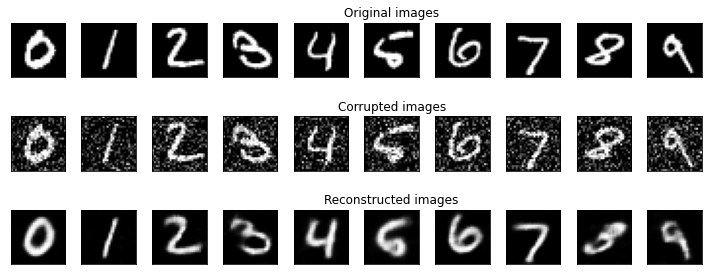

In [ ]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

tensor([0.0089, 0.1030, 0.1120, 0.0550])
tensor([0.6265, 0.6533, 0.6705, 0.6853])


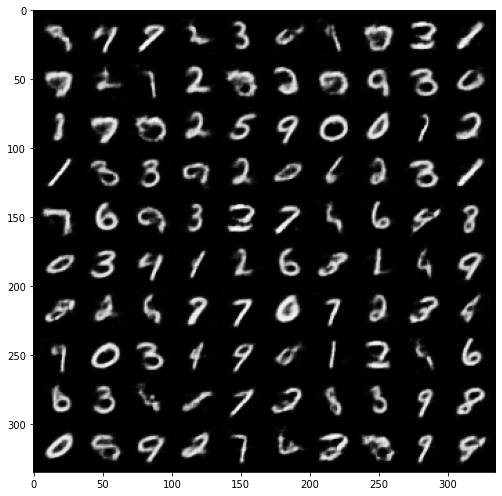

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()